In [1]:
#libraries to be used 
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#function to get data from the API
def getData(url):
    response = requests.get(url)
    if response.status_code == 200:
        print("Valid Data Retrieved")
        return response.json()["data"]
    else:
        print(f"Request failed with status code: {response.status_code}")
        return None

In [3]:
#url is this
url = "https://datausa.io/api/data?drilldowns=Year,Gender,Age&measures=Total+Population&Geography=01000US"
#fetch data 
data = getData(url)
#convert to dataframe 
df = pd.DataFrame(data)

Valid Data Retrieved


In [4]:
#convert "Year" and "Age" columns to integers
#convert Year to integer
df["Year"] = pd.to_numeric(df["Year"]) 
#convert Age to integer
df["Age"] = pd.to_numeric(df["Age"])   

In [5]:
#check if processed 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID Year           1758 non-null   int64 
 1   Year              1758 non-null   int64 
 2   ID Gender         1758 non-null   int64 
 3   Gender            1758 non-null   object
 4   ID Age            1758 non-null   int64 
 5   Age               1758 non-null   int64 
 6   Total Population  1758 non-null   int64 
 7   Geography         1758 non-null   object
 8   ID Geography      1758 non-null   object
 9   Slug Geography    1758 non-null   object
dtypes: int64(6), object(4)
memory usage: 137.5+ KB


,ID Year,Year,ID Gender,Gender,ID Age,Age,Total Population,Geography,ID Geography,Slug Geography
0,2022,2022,1,Male,0,0,1773000,United States,01000US,united-states
1,2022,2022,1,Male,1,1,1912238,United States,01000US,united-states
2,2022,2022,1,Male,2,2,1973523,United States,01000US,united-states
3,2022,2022,1,Male,3,3,2017254,United States,01000US,united-states
4,2022,2022,1,Male,4,4,2067187,United States,01000US,united-states


In [6]:
#extracting only year and total population
dfYearlyPopulation = df.groupby("Year")["Total Population"].sum().reset_index()
#display result
print(dfYearlyPopulation)

   Year  Total Population
0  2014         317746050
1  2015         320098097
2  2016         322087547
3  2017         324473371
4  2018         326289973
5  2019         328016243
6  2020         329824952
7  2021         333036757
8  2022         333864701


In [7]:
#extract data for 2022
df2022 = df[df["Year"] == 2022].copy()
#ensure Age is numeric
df2022["Age"] = pd.to_numeric(df2022["Age"], errors="coerce")
df2022.dropna(subset=["Age"], inplace=True)
#define age bins and labels
bins = [-1, 9, 19, 29, 39, 49, 59, 69, 79, float("inf")]
labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]
#create a new column with age groups
df2022["age_group"] = pd.cut(df2022["Age"], bins=bins, labels=labels, right=True)
#now group by age_group and Gender
df2022Grouped = df2022.groupby(["age_group", "Gender"], observed=False)["Total Population"].sum().unstack()
#reset index to get a clean DataFrame
df2022Grouped.reset_index(inplace=True)
#add Total Population column
df2022Grouped["Total Population"] = df2022Grouped["Male"] + df2022Grouped["Female"]
#display the result
print(df2022Grouped)


Gender age_group    Female      Male  Total Population
0            0-9  19071578  19977897          39049475
1          10-19  21336839  22410139          43746978
2          20-29  22106871  23162053          45268924
3          30-39  22206513  22799495          45006008
4          40-49  20631857  20850562          41482419
5          50-59  21465977  21188521          42654498
6          60-69  20413035  18900902          39313937
7          70-79  13262741  11182322          24445063
8            80+   7890059   5007340          12897399


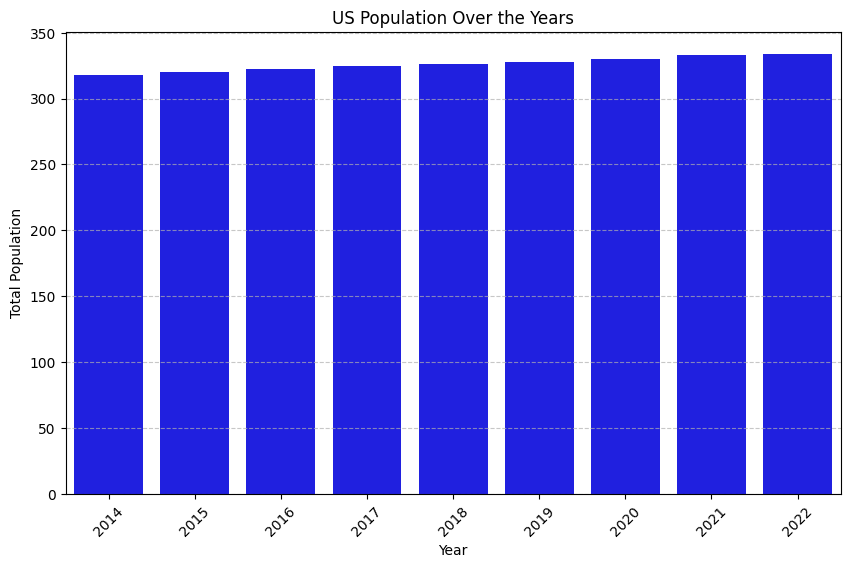

In [8]:
#plotting bar chart of US population over the years
#making sure total population is numeric and scaled properly
dfYearlyPopulation["Total Population"] = pd.to_numeric(dfYearlyPopulation["Total Population"])
dfYearlyPopulation["Total Population"] = dfYearlyPopulation["Total Population"] / 1_000_000

#example color
barColor = "blue" 

#plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Year", y="Total Population", data=dfYearlyPopulation, color=barColor)
plt.xlabel("Year")
plt.ylabel("Total Population")
plt.title("US Population Over the Years")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

C:\Users\19546\AppData\Local\Temp\ipykernel_2200\856613952.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(abs(x) / 1_000_000)}M" for x in xticks])


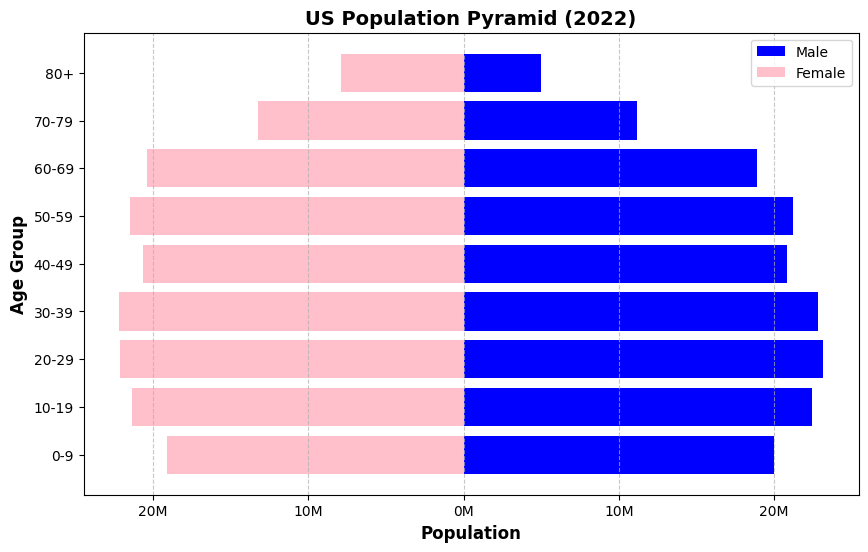

In [9]:
#pyramid chart
#convert female population to negative for visualization
df2022Grouped["Female"] = -df2022Grouped["Female"]

#create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

#plot Male bars
ax.barh(df2022Grouped["age_group"], df2022Grouped["Male"], color="blue", label="Male")

#plot Female bars
ax.barh(df2022Grouped["age_group"], df2022Grouped["Female"], color="pink", label="Female")

#get the x-tick values and manually convert them to millions
xticks = ax.get_xticks()  # Get default x-tick positions
ax.set_xticklabels([f"{int(abs(x) / 1_000_000)}M" for x in xticks])

#labels and formatting
ax.set_xlabel("Population", fontsize=12, fontweight="bold")
ax.set_ylabel("Age Group", fontsize=12, fontweight="bold")
ax.set_title("US Population Pyramid (2022)", fontsize=14, fontweight="bold")
ax.legend()

#add grid lines for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


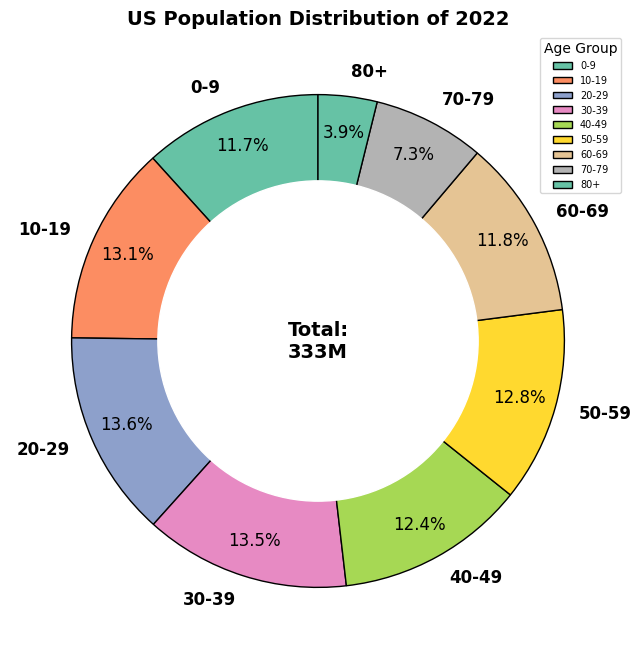

In [10]:
#donut chart for 2022
ageGroupTotals = df2022.groupby("age_group", observed=False)["Total Population"].sum()

#define colors 
colors = sns.color_palette("Set2", len(ageGroupTotals))

#create Donut Chart
fig, ax = plt.subplots(figsize=(8, 8)) 
wedges, texts, autotexts = ax.pie(ageGroupTotals, labels=ageGroupTotals.index, autopct="%1.1f%%", colors=colors, startangle=90, wedgeprops={"edgecolor": "black"}, pctdistance=0.85)

#add a circle in the middle to create a donut effect
center_circle = plt.Circle((0, 0), 0.65, color="white")  
ax.add_artist(center_circle)

#improve text formatting
for text in texts:
    text.set_fontsize(12) 
    text.set_fontweight("bold")

for autotext in autotexts:
    autotext.set_fontsize(12) 

#add total population text in the center
totalPopulation = int(ageGroupTotals.sum() / 1_000_000)  
ax.text(0, 0, f"Total:\n{totalPopulation}M", ha="center", va="center", fontsize=14, fontweight="bold")

#add a legend
ax.legend(labels=ageGroupTotals.index, loc="upper right", title="Age Group", fontsize=7, frameon=True)

#title
plt.title("US Population Distribution of 2022", fontsize=14, fontweight="bold")
plt.show()
